
# Importing modules and tools


In [1]:

%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

from platges_utils.datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset
from frameworks.opencv.homography.homography_matrix import HomographyMatrixEstimator
from frameworks.opencv.homography.homography_matrix import RANSAC_MatrixEstimator, Dense_PointFinder
from frameworks.opencv.homography.translate_mask import translate_mask



# Initial test

If the images are similar, wouldn't they stich correctly authomatically (and their masks with them)?


## First step

Let's define a function to process a pair of images

In [2]:

def compare_masks(mask_1, mask_2):
    ch_0 = (mask_1 == 0) == (mask_2 == 0)
    ch_1 = (mask_1 % 2) == (mask_2 % 2)
    ch_2 = (mask_1 >> 1 % 2) == (mask_2 >> 1 % 2)
    
    final = ch_0.copy()
    final[final == True] = ch_1[final == True] | ch_2[final == True]
    
    return final

def mask_translator(image1, image2, mask1, mask2, step=20, r=10):
    
    point_finder_obj = cv2.SIFT_create()
    point_finder_0 = lambda img, mask : point_finder_obj.detect(img, mask)
    #point_finder_0 = Dense_PointFinder(npoints=1000)
    
    def point_finder(img, mask):
        
        keypoints = point_finder_0(img, mask)
        print(f'Initial point number: {len(keypoints)}')
        return  keypoints
    
    def matrix_finder(kp1, des1, kp2, des2):
                
        bf = cv2.BFMatcher(crossCheck=False) # Brute Force Matcher
        point_matcher = lambda des1, des2 : bf.match(des1, des2)
        matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=5.0, maxIters=5)
        
        H12, matches, inliers_mask = matrix_finder(kp1, des1, kp2, des2)
        
        return H12, matches, inliers_mask
    
    batch_homographies = HomographyMatrixEstimator(point_finder=point_finder, matrix_finder=matrix_finder)
    
    H12, _, _, _ = batch_homographies(image1, image2, None, None)
    try:
        H21 = np.linalg.inv(np.matrix(H12))
    except:
        print(H12)
    
    mask1_h = translate_mask(mask1, image2, H12)
    mask2_h = translate_mask(mask2, image1, H21)
    img1_h  = translate_mask(image1, image2, H12)
    img2_h  = translate_mask(image2, image1, H21)
    
    return mask1_h, mask2_h, img1_h, img2_h

# TODO: homografias => IoU en area solapada
def genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=4000, max_size_y=4000, downsampling=10):

    # Downsampling
    image1 = cv2.cvtColor(np.uint8(image1[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    image2 = cv2.cvtColor(np.uint8(image2[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    mask1 = np.uint8(mask1[::downsampling, ::downsampling])
    mask2 = np.uint8(mask2[::downsampling, ::downsampling])

    # Processing
    mask1_h, mask2_h, img1_h, img2_h = mask_translator(image1, image2, mask1, mask2, step=20, r=10)

    # logging
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]
    
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"\n---\n")

    composed_img = img1_h.copy()
    composed_img[img1_h == 0] = img2_h[img1_h == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (compare_masks(mask1_h, mask2_h) == False).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[(img1_h != 0) & (error_mask == 255)] = (0, 0, 255)
    error_mask_color[(img1_h == 0) & (error_mask == 255)] = (0, 255, 255)
    
    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img



## Second step

Let's load some images and see how it works

Initial point number: 641
Initial point number: 894
Error pixels: 39545
Correct pixels: 154047
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 39545
Correct pixels: 154047

---



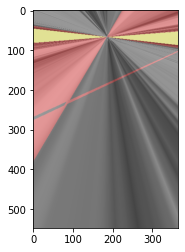

Initial point number: 641
Initial point number: 343
Error pixels: 17923
Correct pixels: 174125
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 17923
Correct pixels: 174125

---



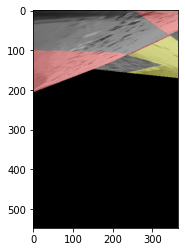

Initial point number: 894
Initial point number: 641
Error pixels: 48039
Correct pixels: 27904
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 48039
Correct pixels: 27904

---



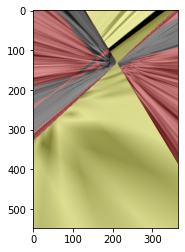

Initial point number: 894
Initial point number: 343
Error pixels: 169640
Correct pixels: 26572
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 169640
Correct pixels: 26572

---



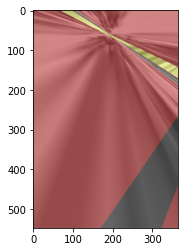

Initial point number: 343
Initial point number: 641
Error pixels: 73740
Correct pixels: 115083
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 73740
Correct pixels: 115083

---



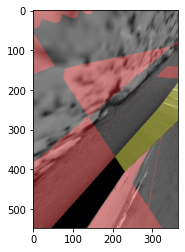

In [3]:

barcos_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

# For the notebook, 1 dataset is enough (adding list(·)[:1])
for dataset_name, dataset in list(datasets.items())[:1]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=10)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1



It is pretty bad... Let's see if handpicking the points works or it is needed to continue with the semantic segmentation.


------

In [ ]:
import os
os._exit(00)
%reset -f

---


# Handpicking points

Will a human pick points better than an algorithm? Or will we discard this idea?

In [4]:

%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pickle



## First step

Defining useful functions.

As it is ugly to work with handpicked points, let's drop a little the coding considerations.

In [5]:

def load_img(img_path, seg_path, cls_path):

    image = cv2.imread(img_path, 0)

    with open(seg_path, 'rb') as f:
        mask = pickle.load(f, encoding='latin1')
    with open(cls_path, 'rb') as f:
        classes = pickle.load(f)

    return image, mask, classes

def homography_matrix_estimator(kp1, kp2, ransac_th=5.0, ransac_maxIters=1000):
    kp1 = np.float32([kp.pt for kp in kp1]).reshape(-1, 1, 2)
    kp2 = np.float32([kp.pt for kp in kp2]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(kp1, kp2, cv2.RANSAC, ransac_th, maxIters=ransac_maxIters)
    return H

def compute_dimensions(composed_img, current_img, homography_matrix):
    h, w = composed_img.shape
    composed_corners = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2).squeeze().astype(int)

    h, w = current_img.shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
    next_corners = cv2.perspectiveTransform(pts, homography_matrix)
    next_corners = np.squeeze(next_corners) # Remove extra dimensions
    next_corners = np.round(next_corners).astype(int)   # Convert to integer

    x_coord = np.concatenate([composed_corners, next_corners]).squeeze()[:,0]
    y_coord =  np.concatenate([composed_corners, next_corners]).squeeze()[:,1]

    max_x = x_coord.max()
    min_x = x_coord.min()
    max_y = y_coord.max()
    min_y = y_coord.min()
    
    return max_x, min_x, max_y, min_y


def compare_masks(mask_1, mask_2):
    ch_0 = (mask_1 == 0) == (mask_2 == 0) # Others
    ch_1 = (mask_1 % 2) == (mask_2 % 2) # 1 or 3
    ch_2 = (mask_1 >> 1 % 2) == (mask_2 >> 1 % 2) # 2 or 3
    
    final = ch_0.copy()
    final[final == True] = ch_1[final == True] | ch_2[final == True]
    
    return final

# TODO: homografias => IoU en area solapada
def genera_error_annotaciones(image1, image2, mask1, mask2, H, max_size_x=4000, max_size_y=4000):

    image1 = np.uint8(image1)
    image2 = np.uint8(image2)
    mask1 = np.uint8(mask1)
    mask2 = np.uint8(mask2)

    # Processing
    max_x, min_x, max_y, min_y = compute_dimensions(image1, image2, H)
    width = int(max_x - min_x + 1)
    height = int(max_y - min_y + 1)
    
    translation_matrix = np.matrix([[1.0, 0.0, -min_x],[0.0, 1.0, -min_y],[0.0, 0.0, 1.0]])
    h = translation_matrix * H # * image

    mask1_h = cv2.warpPerspective(mask1, translation_matrix, (width, height), flags=cv2.INTER_LINEAR) # mask1 translated
    mask2_h = cv2.warpPerspective(mask2, h, (width, height), flags=cv2.INTER_LINEAR) #mask2 homography into 1 translated

    img1_h = cv2.warpPerspective(image1, translation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    img2_h = cv2.warpPerspective(image2, h, (width, height), flags=cv2.INTER_LINEAR)

    # logging
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]
    
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"\n---\n")

    composed_img = img1_h.copy()
    composed_img[img1_h == 0] = img2_h[img1_h == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (compare_masks(mask1_h, mask2_h) == False).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[(img1_h != 0) & (error_mask == 255)] = (0, 0, 255)
    error_mask_color[(img1_h == 0) & (error_mask == 255)] = (0, 255, 255)
    
    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img



## Second step

Let's see what we have


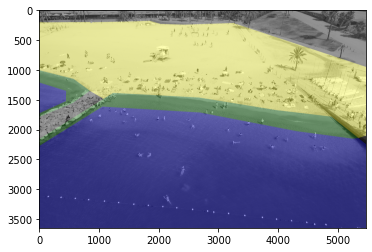

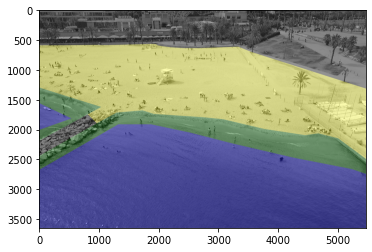

In [6]:
DATA_ROOT = "/mnt/c/Users/Ignasi/Downloads/platgesbcn2021_miniset/barcos_wide/"
IMG1_NAME = "DJI_0581"
IMG2_NAME = "DJI_0722"


IMG1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.JPG"
SEGS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.segments.pkl"
CLS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.classes.pkl"
IMG2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.JPG"
SEGS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.segments.pkl"
CLS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.classes.pkl"


BGR_BLUE = (255, 0, 0)
BGR_YELLOW = (0, 255, 255)
BGR_HALF_GREEN = (0, 128, 0)


image1, mask1, classes1 = load_img(IMG1_PATH, SEGS1_PATH, CLS1_PATH)
image2, mask2, classes2 = load_img(IMG2_PATH, SEGS2_PATH, CLS2_PATH)

def color_mask(mask):
    def color_cls(mask, cls_, color):
        mask_b = (mask == cls_).astype(np.uint8) * 255
        mask_c = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2BGR)
        mask_c[mask_b == 255] = color
        return mask_c
    
    mask_c = cv2.addWeighted(color_cls(mask, 1, BGR_BLUE), 1, color_cls(mask, 2, BGR_YELLOW), 1, 0)
    mask_c = cv2.addWeighted(mask_c, 1, color_cls(mask, 3, BGR_HALF_GREEN), 1, 0)
    return mask_c

mask1_c = cv2.cvtColor(color_mask(mask1), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB), 0.7, mask1_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()

mask2_c = cv2.cvtColor(color_mask(mask2), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB), 0.7, mask2_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()



## Third step

First let's try a dummy code test and have a working example. As we have a test, let's make it easy.

Let's see what happen if the points are coincidents.


[[ 1.00000000e+00  0.00000000e+00 -3.84592537e-16]
 [ 0.00000000e+00  1.00000000e+00 -7.69185075e-16]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Error pixels: 2980215
Correct pixels: 16981641
image1.shape = (3648, 5472)	image2.shape = (3648, 5472)
cropping the upper left corner, shape 8000x8000
Error pixels: 2980215
Correct pixels: 16981641

---



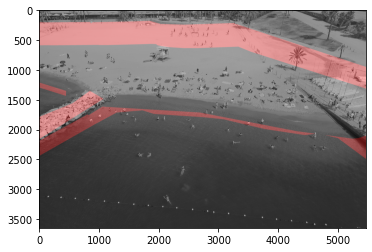

Error pixels: 2980215
Correct pixels: 16981641
image1.shape = (3648, 5472)	image2.shape = (3648, 5472)
cropping the upper left corner, shape 8000x8000
Error pixels: 2980215
Correct pixels: 16981641

---



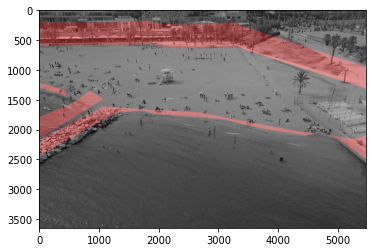

In [7]:

RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(0, 0, RADI),
        cv2.KeyPoint(3, 3, RADI),
        cv2.KeyPoint(0, 3, RADI),
        cv2.KeyPoint(3, 0, RADI)
    ),
    (
        cv2.KeyPoint(0, 0, RADI),
        cv2.KeyPoint(3, 3, RADI),
        cv2.KeyPoint(0, 3, RADI),
        cv2.KeyPoint(3, 0, RADI)
    )
)

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()



## Fourth step

Now, let's play with the point coordinates.


[[ 9.53919661e-01 -8.57139022e-02  1.78843541e+02]
 [ 6.17616984e-04  9.46857610e-01  3.93112111e+02]
 [-3.78220725e-06 -1.92933800e-05  1.00000000e+00]]

Error pixels: 3054456
Correct pixels: 19959288
image1.shape = (4067, 5697)	image2.shape = (4067, 5697)
cropping the upper left corner, shape 8000x8000
Error pixels: 3054456
Correct pixels: 19959288

---



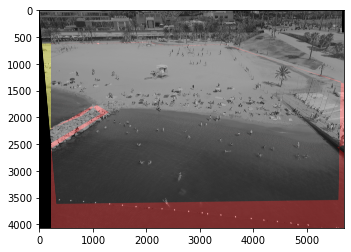

Error pixels: 310145
Correct pixels: 20672761
image1.shape = (4236, 5740)	image2.shape = (4236, 5740)
cropping the upper left corner, shape 8000x8000
Error pixels: 310145
Correct pixels: 20672761

---



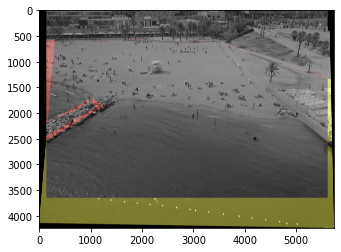

In [8]:
RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(4197, 1165, RADI),
        cv2.KeyPoint(2046, 711, RADI),
        cv2.KeyPoint(781, 199, RADI),
        cv2.KeyPoint(3509, 326, RADI),
        cv2.KeyPoint(586, 1708, RADI)
    ),
    (
        cv2.KeyPoint(426, 1564, RADI),
        cv2.KeyPoint(2115, 1091, RADI),
        cv2.KeyPoint(913, 586, RADI),
        cv2.KeyPoint(3568, 718, RADI),
        cv2.KeyPoint(613, 2084, RADI)
    )
)

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

The red color is the error inside the "unlabeled" image while the yellow color is the label outside the "unlabeled" image.

It seems that it is possible. Most of the error is from areas not visible on both images and irregular contours.


## Fifth step

Let's try with other images.


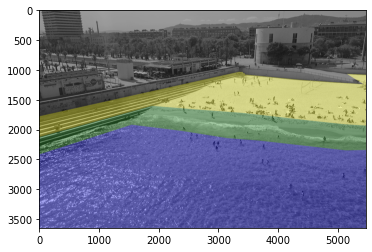

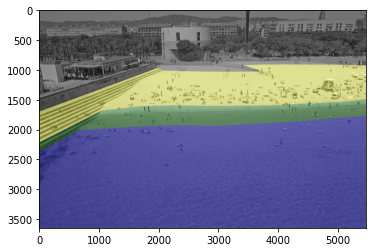

[[ 2.38384615e+00  5.72033887e-01 -5.11775517e+03]
 [ 1.92767269e-01  1.31473614e+00 -2.94199373e+02]
 [ 2.80188057e-04 -1.75583816e-04  1.00000000e+00]]

Error pixels: 4572036
Correct pixels: 91611448
image1.shape = (6311, 16362)	image2.shape = (6311, 16362)
cropping the upper left corner, shape 20000x20000
Error pixels: 4572036
Correct pixels: 91611448

---



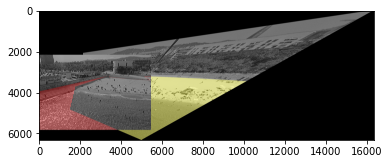

Error pixels: 2777484
Correct pixels: 120504537
image1.shape = (12809, 13901)	image2.shape = (12809, 13901)
cropping the upper left corner, shape 20000x20000
Error pixels: 2777484
Correct pixels: 120504537

---



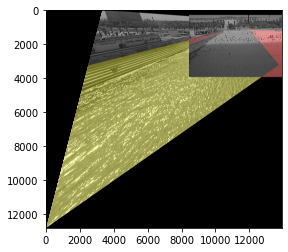

In [9]:
DATA_ROOT = "/mnt/c/Users/Ignasi/Downloads/platgesbcn2021_miniset/gradas_wide/"
IMG1_NAME = "DJI_0701"
IMG2_NAME = "DJI_0788"

RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(3352, 1032, RADI),
        cv2.KeyPoint(5416, 1283, RADI),
        cv2.KeyPoint(3658, 1189, RADI),
        cv2.KeyPoint(4386, 1392, RADI)
        #, cv2.KeyPoint(5049, 1209, RADI)
    ),
    (
        cv2.KeyPoint(1970, 972, RADI),
        cv2.KeyPoint(3720, 1063, RADI),
        cv2.KeyPoint(2358, 1087, RADI),
        cv2.KeyPoint(3091, 1200, RADI)
        #, cv2.KeyPoint(3435, 1028, RADI)
    )
)

########################################################

IMG1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.JPG"
SEGS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.segments.pkl"
CLS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.classes.pkl"
IMG2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.JPG"
SEGS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.segments.pkl"
CLS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.classes.pkl"

BGR_BLUE = (255, 0, 0)
BGR_YELLOW = (0, 255, 255)
BGR_HALF_GREEN = (0, 128, 0)


image1, mask1, classes1 = load_img(IMG1_PATH, SEGS1_PATH, CLS1_PATH)
image2, mask2, classes2 = load_img(IMG2_PATH, SEGS2_PATH, CLS2_PATH)

mask1_c = cv2.cvtColor(color_mask(mask1), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB), 0.7, mask1_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()

mask2_c = cv2.cvtColor(color_mask(mask2), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB), 0.7, mask2_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()


H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()


[[ 1.72035566e+00  1.28631043e+00 -4.06397919e+03]
 [ 6.93031362e-02  1.33335367e+00 -1.13258190e+02]
 [ 1.49625563e-04  3.54552282e-05  1.00000000e+00]]

Error pixels: 1302471
Correct pixels: 50900023
image1.shape = (5436, 11175)	image2.shape = (5436, 11175)
cropping the upper left corner, shape 20000x20000
Error pixels: 1302471
Correct pixels: 50900023

---



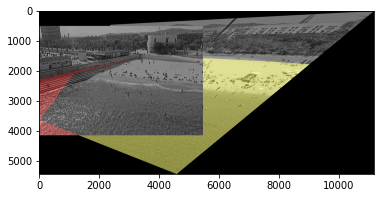

Error pixels: 3799509
Correct pixels: 35025370
image1.shape = (4320, 9536)	image2.shape = (4320, 9536)
cropping the upper left corner, shape 20000x20000
Error pixels: 3799509
Correct pixels: 35025370

---



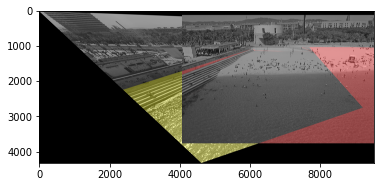

In [10]:
RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(3352, 1032, RADI),
        cv2.KeyPoint(5416, 1283, RADI),
        cv2.KeyPoint(3658, 1189, RADI),
        cv2.KeyPoint(4386, 1392, RADI)
        , cv2.KeyPoint(5049, 1209, RADI)
    ),
    (
        cv2.KeyPoint(1970, 972, RADI),
        cv2.KeyPoint(3720, 1063, RADI),
        cv2.KeyPoint(2358, 1087, RADI),
        cv2.KeyPoint(3091, 1200, RADI)
        , cv2.KeyPoint(3435, 1028, RADI)
    )
)

########################################################

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

The stiching is not that good but the mask should be reusable. Comparing the 4 and 5 points homography estimation, the 5 points is able to handle better the bleachers than the 4 points one.


---


In [ ]:
import os
os._exit(00)
%reset -f


---


In [12]:

%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

from platges_utils.datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset
from frameworks.opencv.homography.homography_matrix import HomographyMatrixEstimator
from frameworks.opencv.homography.homography_matrix import RANSAC_MatrixEstimator, Dense_PointFinder
from frameworks.opencv.homography.translate_mask import translate_mask


# Function to display one image
def display_image(img, title='', size=None, show_axis=False):
    plt.gray()
    if not show_axis:
      plt.axis('off')
    h = plt.imshow(img, interpolation='none')
    if size:
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth(img.shape[1] / dpi)
        h.figure.set_figheight(img.shape[0] / dpi)
        h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
        h.axes.set_position([0, 0, 1, 1])
        if show_axis:
            h.axes.set_xlim(-1, img.shape[1])
            h.axes.set_ylim(img.shape[0], -1)
    plt.grid(False)
    plt.title(title)  
    plt.show()



In [20]:

def compare_masks(mask_1, mask_2):
    ch_0 = (mask_1 == 0) == (mask_2 == 0)
    ch_1 = (mask_1 % 2) == (mask_2 % 2)
    ch_2 = (mask_1 >> 1 % 2) == (mask_2 >> 1 % 2)
    
    final = ch_0.copy()
    final[final == True] = ch_1[final == True] | ch_2[final == True]
    
    return final

def mask_translator(image1, image2, mask1, mask2, step=20, r=10):
    
    point_finder_obj = cv2.SIFT_create()
    point_finder_0 = lambda img, mask : point_finder_obj.detect(img, mask)
    #point_finder_0 = Dense_PointFinder(npoints=1000)
    
    def point_finder(img, mask):
        
        keypoints = point_finder_0(img, mask)
        print(f'Initial point number: {len(keypoints)}')
        return  keypoints
    
    def matrix_finder(kp1, des1, kp2, des2):
                
        bf = cv2.BFMatcher(crossCheck=False) # Brute Force Matcher
        point_matcher = lambda des1, des2 : bf.match(des1, des2)
        matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=5.0, maxIters=5)
        
        H12, matches, inliers_mask = matrix_finder(kp1, des1, kp2, des2)
        
        return H12, matches, inliers_mask
    
    batch_homographies = HomographyMatrixEstimator(point_finder=point_finder, matrix_finder=matrix_finder)
    
    H12, _, _, _ = batch_homographies(image1, image2, None, None)
    try:
        H21 = np.linalg.inv(np.matrix(H12))
    except:
        print(H12)
    
    mask1_h = translate_mask(mask1, image2, H12)
    mask2_h = translate_mask(mask2, image1, H21)
    img1_h  = translate_mask(image1, image2, H12)
    img2_h  = translate_mask(image2, image1, H21)
    
    return mask1_h, mask2_h, img1_h, img2_h

# TODO: homografias => IoU en area solapada
def genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=4000, max_size_y=4000, downsampling=10, MATCHES_VERBOSE=True):

    # Downsampling
    image1 = cv2.cvtColor(np.uint8(image1[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    image2 = cv2.cvtColor(np.uint8(image2[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    mask1 = np.uint8(mask1[::downsampling, ::downsampling])
    mask2 = np.uint8(mask2[::downsampling, ::downsampling])

    # Processing
    mask1_h, mask2_h, img1_h, img2_h = mask_translator(image1, image2, mask1, mask2, step=20, r=10)

    # logging
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]
    
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"\n---\n")

    composed_img = img1_h.copy()
    composed_img[img1_h == 0] = img2_h[img1_h == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (compare_masks(mask1_h, mask2_h) == False).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[(img1_h != 0) & (error_mask == 255)] = (0, 0, 255)
    error_mask_color[(img1_h == 0) & (error_mask == 255)] = (0, 255, 255)
    
    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img


Initial point number: 641
Initial point number: 894
Error pixels: 39545
Correct pixels: 154047
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 39545
Correct pixels: 154047

---



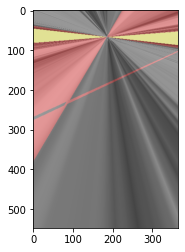

Initial point number: 641
Initial point number: 343
Error pixels: 17923
Correct pixels: 174125
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 17923
Correct pixels: 174125

---



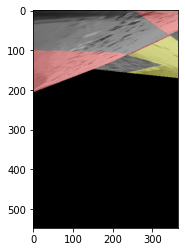

Initial point number: 894
Initial point number: 641
Error pixels: 48039
Correct pixels: 27904
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 48039
Correct pixels: 27904

---



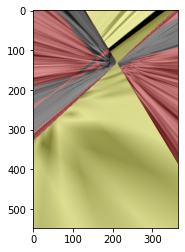

Initial point number: 894
Initial point number: 343
Error pixels: 169640
Correct pixels: 26572
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 169640
Correct pixels: 26572

---



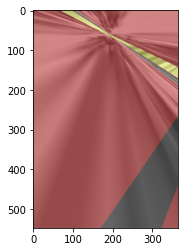

Initial point number: 343
Initial point number: 641
Error pixels: 73740
Correct pixels: 115083
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 73740
Correct pixels: 115083

---



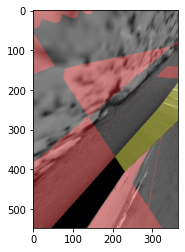

In [21]:

barcos_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

for dataset_name, dataset in list(datasets.items())[:1]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=10, MATCHES_VERBOSE=True)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1


Initial point number: 1659
Initial point number: 1080
Error pixels: 13670
Correct pixels: 185147
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 13670
Correct pixels: 185147

---



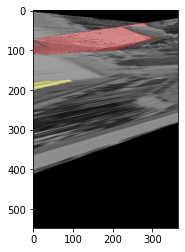

Initial point number: 1080
Initial point number: 1659
Error pixels: 51134
Correct pixels: 143160
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 51134
Correct pixels: 143160

---



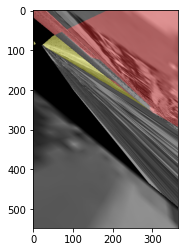

In [22]:

barcos_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

for dataset_name, dataset in list(datasets.items())[1:2]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=10, MATCHES_VERBOSE=True)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1

Initial point number: 1282
Initial point number: 1230
Error pixels: 25420
Correct pixels: 171047
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 25420
Correct pixels: 171047

---



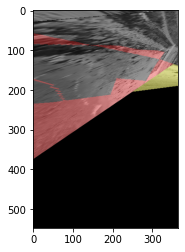

Initial point number: 1282
Initial point number: 931
Error pixels: 23381
Correct pixels: 160521
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 23381
Correct pixels: 160521

---



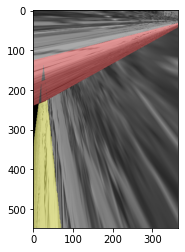

Initial point number: 1230
Initial point number: 1282
Error pixels: 26130
Correct pixels: 172545
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 26130
Correct pixels: 172545

---



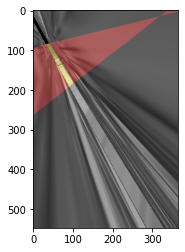

Initial point number: 1230
Initial point number: 931
Error pixels: 4499
Correct pixels: 173154
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 4499
Correct pixels: 173154

---



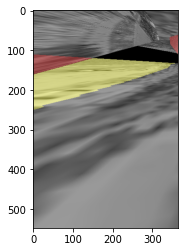

Initial point number: 931
Initial point number: 1282
Error pixels: 174239
Correct pixels: 25746
image1.shape = (548, 365)	image2.shape = (548, 365)
cropping the upper left corner, shape 2000x2000
Error pixels: 174239
Correct pixels: 25746

---



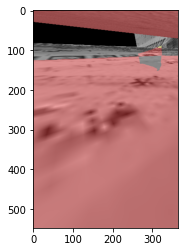

In [23]:

barcos_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

for dataset_name, dataset in list(datasets.items())[2:]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=10, MATCHES_VERBOSE=True)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1

---

In [24]:
def genera_error_annotaciones(mask_translator, image1, image2, mask1, mask2, max_size_x=4000, max_size_y=4000, downsampling=10, MATCHES_VERBOSE=True, to_gray=False):

    # Downsampling
    if downsampling is not None:
        image1 = np.uint8(image1[::downsampling, ::downsampling])
        image2 = np.uint8(image2[::downsampling, ::downsampling])
        mask1 = np.uint8(mask1[::downsampling, ::downsampling])
        mask2 = np.uint8(mask2[::downsampling, ::downsampling])
    
    if to_gray: 
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Processing
    mask1_h, mask2_h, img1_h, img2_h = mask_translator(image1, image2, mask1, mask2, step=20, r=10)

    # logging
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]
    
    print(f"Error pixels: {np.sum((compare_masks(mask1_h, mask2_h) == False)[img1_h != 0])}")
    print(f"Correct pixels: {np.sum(compare_masks(mask1_h, mask2_h))}")
    print(f"\n---\n")

    composed_img = img1_h.copy()
    composed_img[img1_h == 0] = img2_h[img1_h == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (compare_masks(mask1_h, mask2_h) == False).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[(img1_h != 0) & (error_mask == 255)] = (0, 0, 255)
    error_mask_color[(img1_h == 0) & (error_mask == 255)] = (0, 255, 255)
    
    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img

In [25]:

import torch
from types import SimpleNamespace

from frameworks.pytorch.utils.scales_process import torch_batch_scales_process_numpy
from platges_utils.datasets.augmented_datasets import build_test_dataset
from platges_utils.model.pyconvsegnet import build_PyConvSegNet_from_params


def unNormalize(tensor, mean, std):
    # tensor: (C, H, W)
    for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
    return tensor


WATER_ID = 1
SAND_ID = 2
OTHERS_ID = 0
CLASSES_COLOR = {
    WATER_ID : 'BLUE',
    SAND_ID : 'YELLOW',
    OTHERS_ID : 'GRAY'
}

MEAN = [0.485, 0.456, 0.406] # PyConvSegNet values
STD = [0.229, 0.224, 0.225] # PyConvSegNet values
VALUE_SCALE = 255
params = SimpleNamespace(
    # Parameters updated from data
    mean = [item * VALUE_SCALE for item in MEAN],
    std = [item * VALUE_SCALE for item in STD],
    # Modifiable hyperparams:
    # (add new hyperparameters for any optim, loss, etc)
    num_classes = 3,
    gamma = 2, # if focal_loss
    stride_rate = 2/3,
    scales = [1.0],
    # Data Augmentation parameters:
    resize_height = 512,
    resize_width = 696,
    crop_height = 473,
    crop_width = 473,
    # PyConvSegNet hyperparams:
    funnel_map = True,
    zoom_factor = 8,
    layers = 152,
    num_classes_pretrain = 150,
    backbone_output_stride = 8,
    backbone_net = "pyconvresnet",
    # Pre-trained pathes
    pretrained_back_path = None,
    adapt_state_dict = False,
    pretrained_path = 'model_parameters/segments_platgesBCN/pyconvsegnet_platgesBCN_test.pth'
)


In [27]:
device = torch.device('cpu')
model = build_PyConvSegNet_from_params(params).to(device)

def point_finder_descriptor(img, other):
    descriptor = cv2.SIFT_create()
            
    output = torch_batch_scales_process_numpy(model,
                                              img.unsqueeze(0),
                                              params.num_classes,
                                              params.crop_height,
                                              params.crop_width,
                                              params.mean,
                                              params.std,
                                              params.scales,
                                              base_size=0,
                                              stride_rate=params.stride_rate, 
                                              device=device)
    
    img2 = img.clone()
    
    img2 = cv2.cvtColor(img2.numpy(), cv2.COLOR_RGB2GRAY) # .cpu()?
    img2[output != SAND_ID] = 0 # Only 1 image, batch defined at the input just before
    
    return descriptor.detectAndCompute(img2, mask=None)

def mask_translator(image1, image2, mask1, mask2, step=20, r=10):
    # TODO: Change point_finder and descriptor_finder
    point_finder_obj = cv2.SIFT_create()
    point_finder_0 = lambda img, mask : point_finder_obj.detect(img, mask)
    #point_finder_0 = Dense_PointFinder(npoints=1000)
    
    def point_finder(img, mask):
        
        keypoints = point_finder_0(img, mask)
        print(f'Initial point number: {len(keypoints)}')
        return  keypoints
    
    def matrix_finder(kp1, des1, kp2, des2):
                
        bf = cv2.BFMatcher(crossCheck=False) # Brute Force Matcher
        point_matcher = lambda des1, des2 : bf.match(des1, des2)
        matrix_finder = RANSAC_MatrixEstimator(point_matcher=point_matcher, min_match_count=4, ransacReprojThreshold=5.0, maxIters=5)
        
        H12, matches, inliers_mask = matrix_finder(kp1, des1, kp2, des2)
        
        return H12, matches, inliers_mask
    
    batch_homographies = HomographyMatrixEstimator(point_finder=point_finder, matrix_finder=matrix_finder)
    
    H12, _, _, _ = batch_homographies(image1, image2, None, None)
    try:
        H21 = np.linalg.inv(np.matrix(H12))
    except:
        print(H12)
    
    mask1_h = translate_mask(mask1, image2, H12)
    mask2_h = translate_mask(mask2, image1, H21)
    img1_h  = translate_mask(image1, image2, H12)
    img2_h  = translate_mask(image2, image1, H21)
    
    return mask1_h, mask2_h, img1_h, img2_h


In [28]:
from platges_utils.datasets.augmented_datasets import build_test_dataset

barcos_wide_ori = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide_ori = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide_ori = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

barcos_wide = build_test_dataset(barcos_wide_ori, params.resize_height, params.resize_width, params.mean, params.std)
gradas_wide = build_test_dataset(gradas_wide_ori, params.resize_height, params.resize_width, params.mean, params.std)
pipican_wide = build_test_dataset(pipican_wide_ori, params.resize_height, params.resize_width, params.mean, params.std)


datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

for dataset_name, dataset in list(datasets.items())[1:2]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(mask_translator, image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=None, MATCHES_VERBOSE=True)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                display_image(img_ref, 'matches', size=1)
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'detect'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'
>  - Can't parse 'images'. Input argument doesn't provide sequence protocol
>  - Can't parse 'images'. Input argument doesn't provide sequence protocol
